In [1]:
# Cheng S et al. A pan-cancer single-cell transcriptional atlas of tumor infiltrating myeloid cells. Cell 2021 
# https://www.sciencedirect.com/science/article/pii/S0092867421000106
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154763
# https://nbisweden.github.io/workshop-scRNAseq/

In [2]:
#!mkdir data
#!mkdir write
#!mkdir figures

In [3]:
import time; start = time.time()

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
import os; os.makedirs('data/results/', exist_ok=True)
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
#import sc_toolbox.api as sct
import scrublet as scr
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np
import anndata
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-10-13 00:12.


In [6]:
sc.settings.set_figure_params(scanpy=True, dpi=150, dpi_save=150, color_map='coolwarm',facecolor='white',
                             format='png', transparent=False, frameon=False, vector_friendly=True, fontsize=14)
sc.settings.verbosity = 0    # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.6


#   =   =   =   =    =   =   =   =   1. Get Data   =   =   =   =    =   =   =   =   

In [7]:
results_file  = "./write/pbmc3k.h5ad"          # the file that will store the analysis results
data_file     = "./data/GSE154763_UCEC_norm_expression.csv.gz"
metadata_file = "./data/GSE154763_UCEC_metadata.csv.gz"

In [8]:
%%time
UCEC     = pd.read_csv(data_file, index_col=0)
cellinfo = pd.read_csv(metadata_file, index_col=0)
geneinfo = pd.DataFrame(UCEC.columns, index=UCEC.columns, columns=['genes_index'])

Wall time: 1min 16s


In [9]:
%%time
adata = sc.AnnData(UCEC, obs=cellinfo, var = geneinfo)

Wall time: 255 ms


In [10]:
adata.var_names_make_unique()  # unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

#   =   =   =   =    =   =   =   =   2. Create One Merged Object   =   =   =   =    =   =   =   =   

In [11]:
# merge into one object.
#adata = adata.concatenate(adata1, adata2, etc)

In [12]:
adata

AnnData object with n_obs × n_vars = 8808 × 15849
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2'
    var: 'genes_index'

In [13]:
adata.obs.head(3)

percent_mito  n_counts  percent_hsp           barcode  \
index                                                                        
AAACCTGAGTTCGCAT-73      0.027192    6546.0     0.000917  AAACCTGAGTTCGCAT   
AAAGCAACAGACGCCT-73      0.029914   15177.0     0.004612  AAAGCAACAGACGCCT   
AACACGTCATATGGTC-73      0.038902    9691.0     0.005572  AACACGTCATATGGTC   

                     batch        library_id cancer    patient tissue  \
index                                                                   
AAACCTGAGTTCGCAT-73     73  UCEC-P20190312-N   UCEC  P20190312      N   
AAAGCAACAGACGCCT-73     73  UCEC-P20190312-N   UCEC  P20190312      N   
AACACGTCATATGGTC-73     73  UCEC-P20190312-N   UCEC  P20190312      N   

                     n_genes     MajorCluster    source  tech     UMAP1  \
index                                                                     
AAACCTGAGTTCGCAT-73     1634  M08_Macro_NLRP3  ZhangLab  10X5  0.169033   
AAAGCAACAGACGCCT-73     2782    M04_cDC2_CD1C  ZhangLab  10X5 -1.294731   
AACACGTCATATGGTC-73     2046  M09_Macro_ISG15  ZhangLab  10X5  0.878571   

                        UMAP2  
index                          
AAACCTGAGTTCGCAT-73  7.259280  
AAAGCAACAGACGCCT-73  2.460220  
AACACGTCATATGGTC-73  1.648734

In [14]:
adata.obs.patient.value_counts()

P20190911    3965
P20190910    2543
P20181122     609
P20190305     513
P20190717     349
P20190213     334
P20190625     254
P20190312     189
P20181211      52
Name: patient, dtype: int64

#   =   =   =   =    =   =   =   =   3. Quality Control   =   =   =   =    =   =   =   =   

In [15]:
adata.var['mt']   = adata.var_names.str.startswith('MT-')         # annotate mitochondrial genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes
adata.var['hb']   = adata.var_names.str.contains(("^HB[^(P)]"))   # annotate hemoglobin genes.
adata.var.head(3)

genes_index     mt   ribo     hb
FO538757.2        FO538757.2  False  False  False
AP006222.2        AP006222.2  False  False  False
RP4-669L17.10  RP4-669L17.10  False  False  False

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True) # Calculate quality control metrics.

In [17]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [18]:
adata

AnnData object with n_obs × n_vars = 8808 × 15849
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2'
    var: 'genes_index', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#   =   =   =   =    =   =   =   =   4. Plot Quality Control Metrics   =   =   =   =    =   =   =   =   

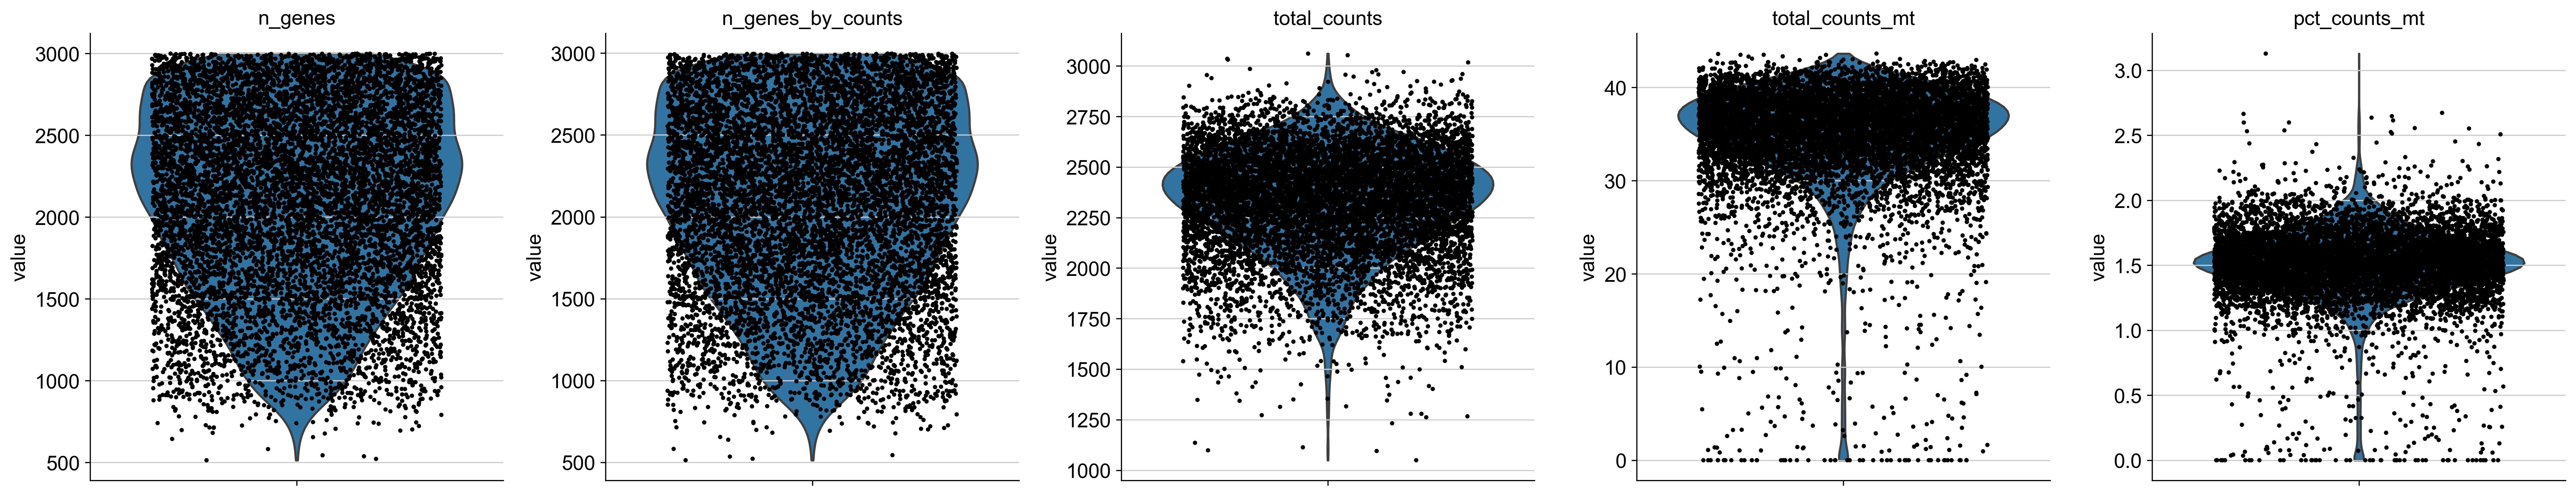

In [19]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.violin(adata, ['n_genes','n_genes_by_counts', 'total_counts','total_counts_mt', 'pct_counts_mt'],
                 size=3, jitter=0.35, multi_panel=True, show=False)
    plt.tight_layout()
    plt.savefig("./figures/01a.QC_ViolinPlots.png", bbox_inches="tight")

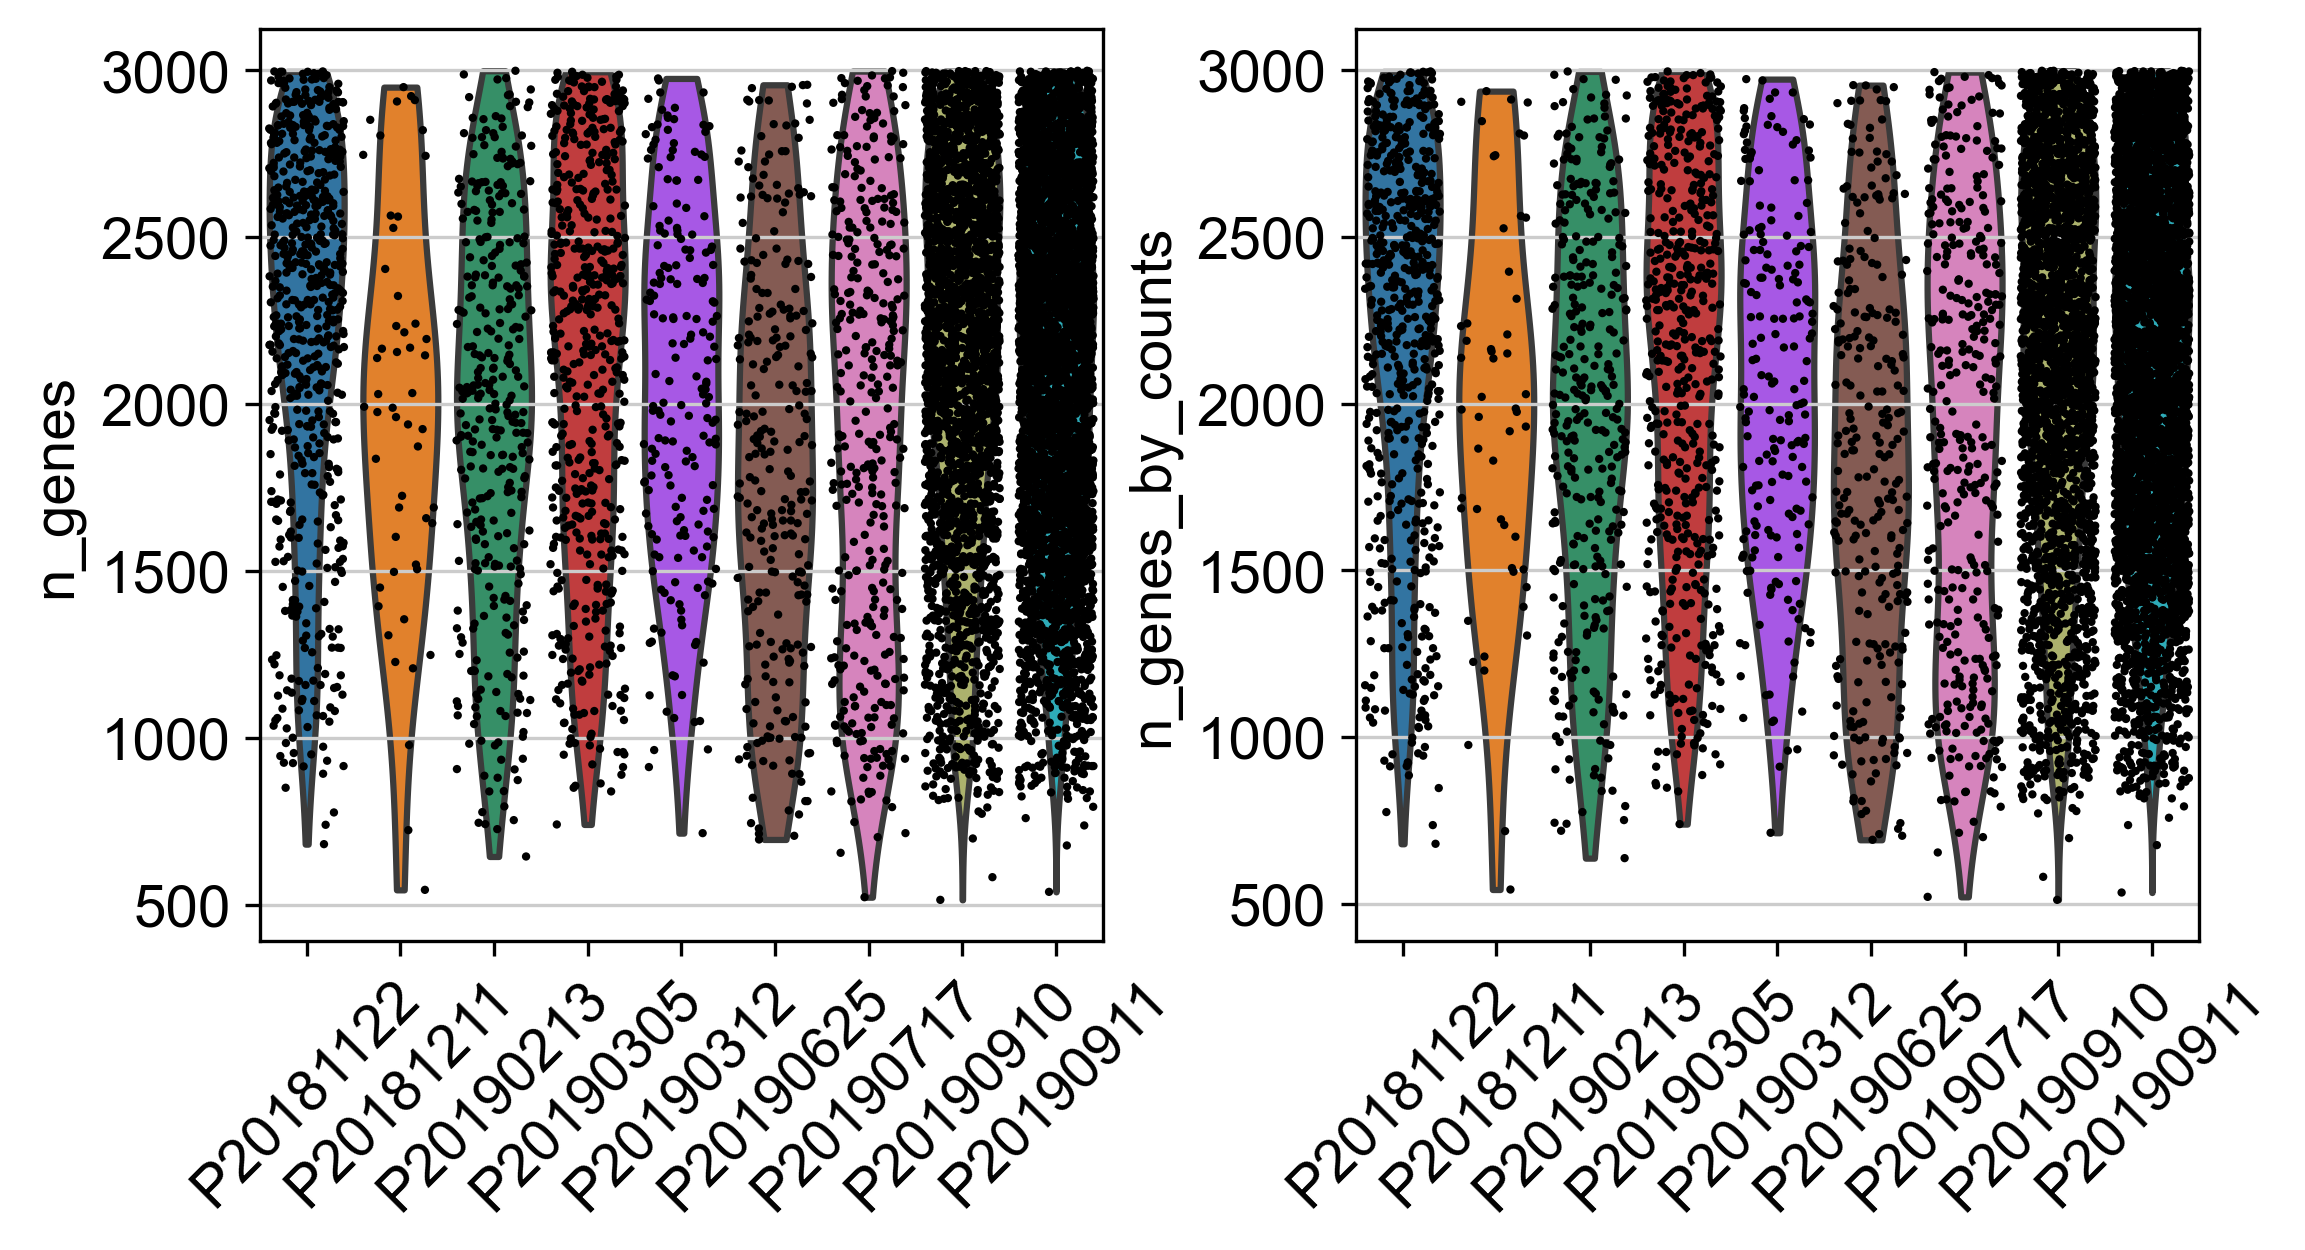

In [20]:
sc.pl.violin(adata, ['n_genes','n_genes_by_counts'], size=2, jitter=0.4, groupby='patient', rotation= 45)

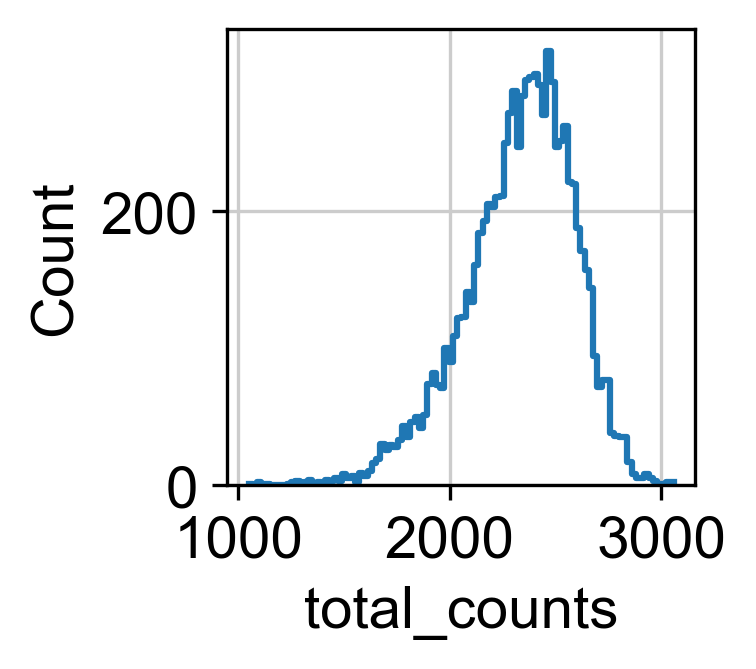

In [21]:
fig,(ax1) = plt.subplots(1,1, figsize=(2,2))
ax1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, element="step", fill=False, ax=ax1)
#plt.savefig("test.png", bbox_inches="tight")

In [22]:
# https://stackoverflow.com/questions/67157280/using-seaborn-displot-i-am-unable-to-specify-the-hue-to-separate-three-categorie

# = = = = = = = = 5. Filtering = = = = = = = =

In [23]:
sc.pp.filter_cells(adata, min_genes = 200) # Filter cell outliers based on counts and numbers of genes expressed.
sc.pp.filter_genes(adata, min_cells = 3)   # Filter genes based on number of cells or counts.
print(adata.n_obs, adata.n_vars)

8808 15847


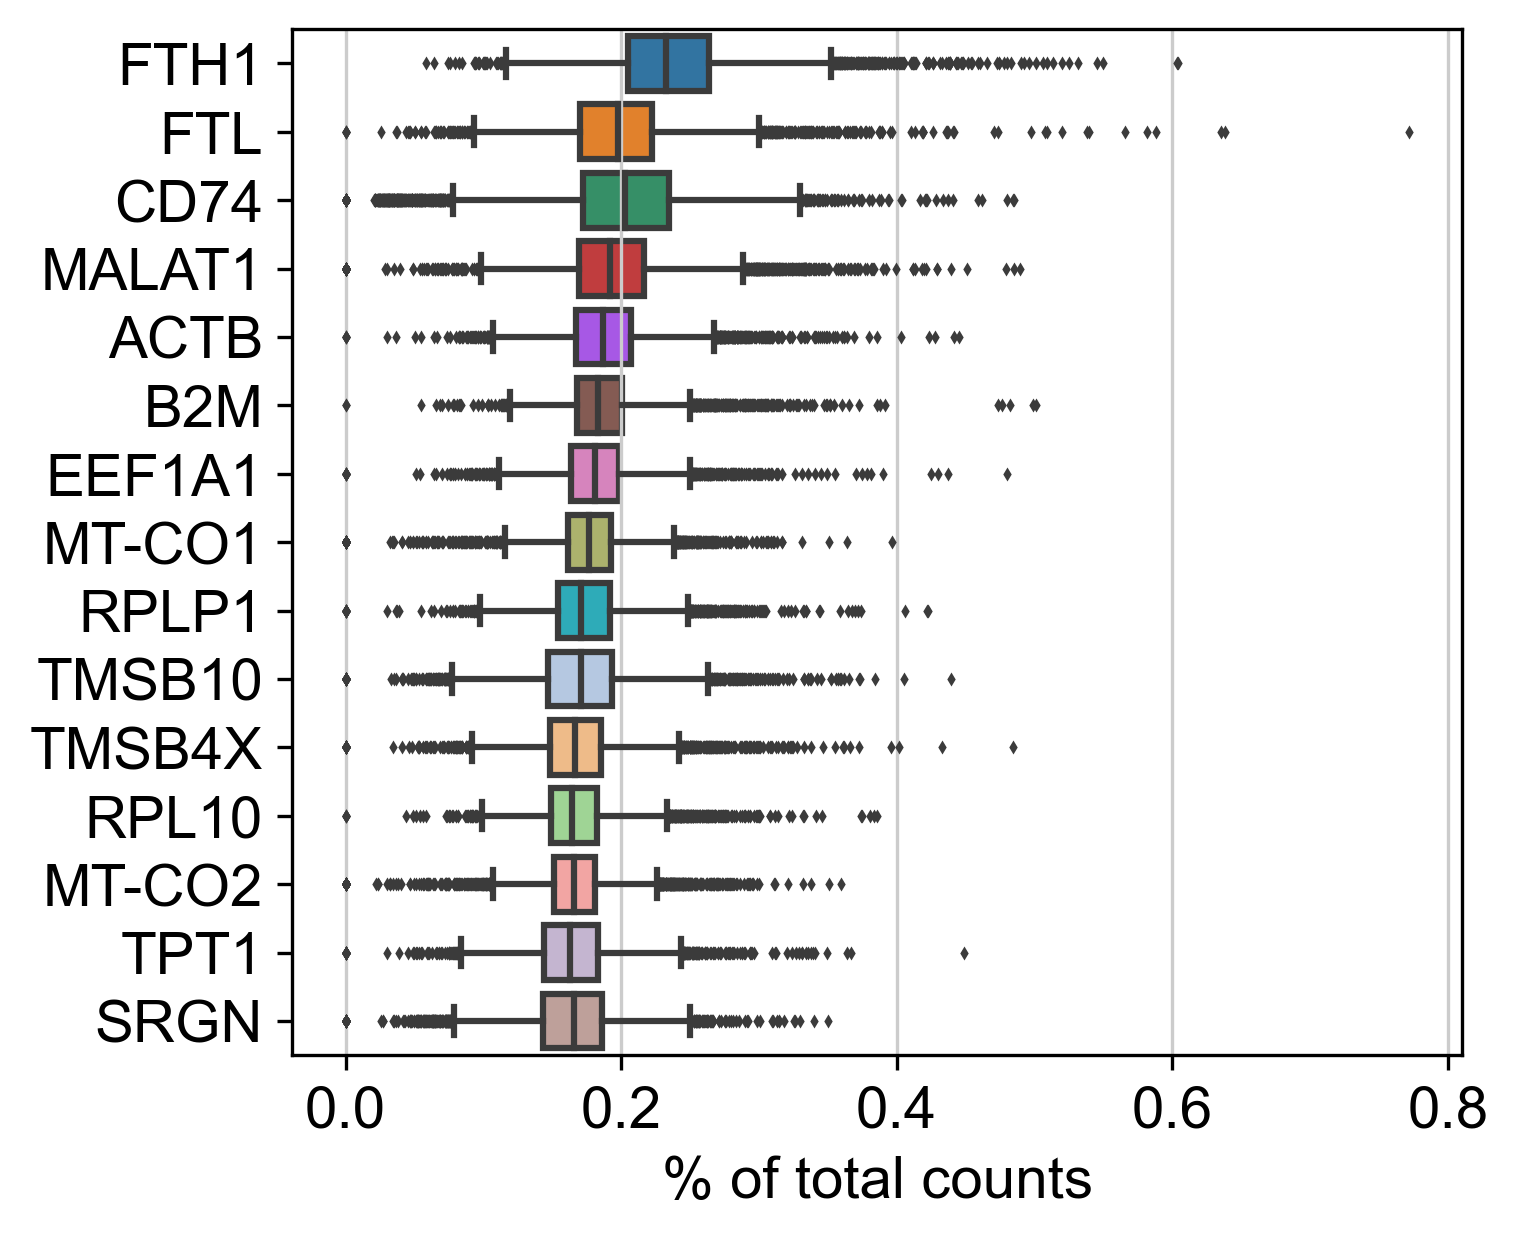

In [24]:
# Preprocessing. Show those genes that yield the highest fraction of counts in each single cell, across all cells.
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.highest_expr_genes(adata, n_top=15, show=False)
    plt.savefig("./figures/01a.HighestFractionCounts.png", bbox_inches="tight")

C:\Users\alber\AppData\Local\Temp/ipykernel_12396/2516360912.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


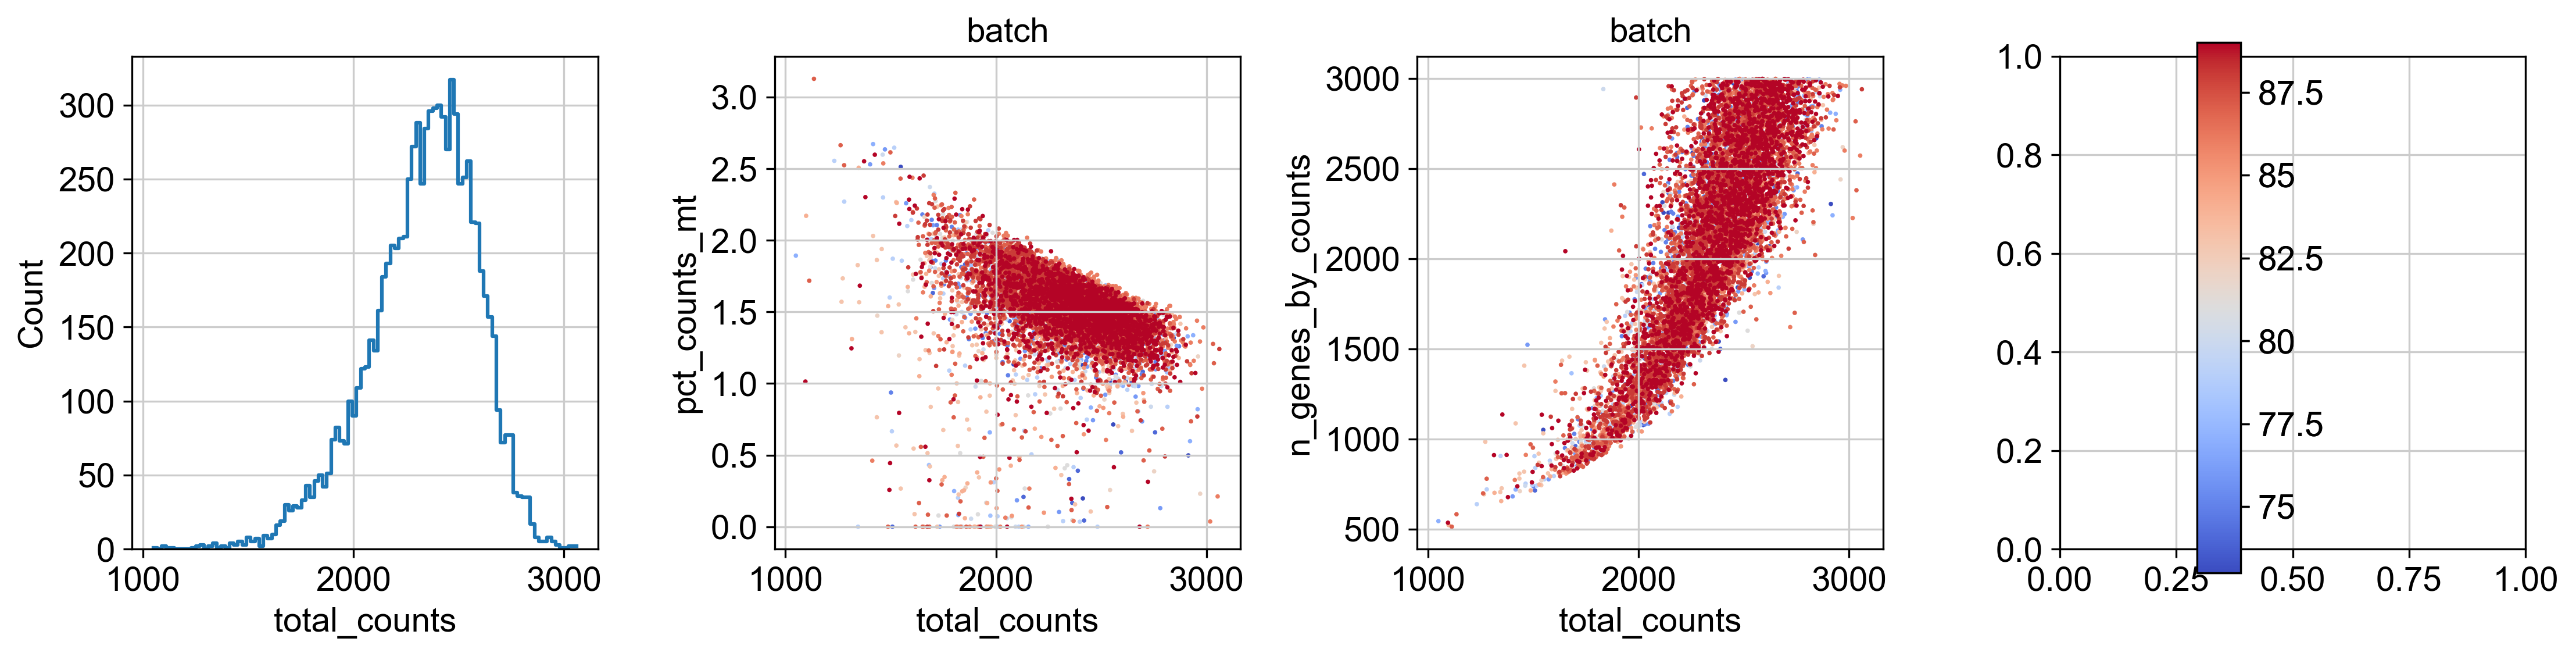

In [25]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,4))
ax1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, element="step", fill=False, ax=ax1)
ax2 = sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='batch',     show=False,  legend_loc='right margin',  ax=ax2)
ax3 = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='batch', show=False,  legend_loc='right margin',  ax=ax3)
plt.tight_layout()
plt.savefig("./figures/01c.QC.png", bbox_inches="tight")

In [26]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]   # filter for percent mito
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]   # filter for percent ribo > 0.05
print("Remaining cells %d"%adata.n_obs)

Remaining cells 8764


In [27]:
# we need to redefine the mito_genes since they were first calculated on the full object before removing low expressed genes.
malat1     = adata.var_names.str.startswith('MALAT1')
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes   = adata.var_names.str.contains('^HB[^(P)]')
remove     = np.add(mito_genes, malat1)
remove     = np.add(remove, hb_genes)
keep       = np.invert(remove)
adata      = adata[:,keep]
print(adata.n_obs, adata.n_vars)

8764 15831


In [28]:
print('Total number of observations before cell filter: {:d}'.format(adata.n_obs))
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print('Total number of observations after cell filter:  {:d}'.format(adata.n_obs))

Total number of observations before cell filter: 8764
Total number of observations after cell filter:  6219


In [29]:
sc.pp.normalize_total(adata, target_sum=1e4) # Normalize counts per cell.
sc.pp.log1p(adata)                           # Logarithmize the data.

C:\Users\alber\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)  # Identify highly-variable genes.
adata = adata[:, adata.var.highly_variable]                                    # Actually do the filtering

In [31]:
adata

View of AnnData object with n_obs × n_vars = 6219 × 2222
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2'
    var: 'genes_index', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'patient_colors', 'log1p', 'hvg'

C:\Users\alber\AppData\Local\Temp/ipykernel_12396/970347180.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "log" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./figures/01d.HighlyVariableGenes.png", bbox_inches="tight", log=True)


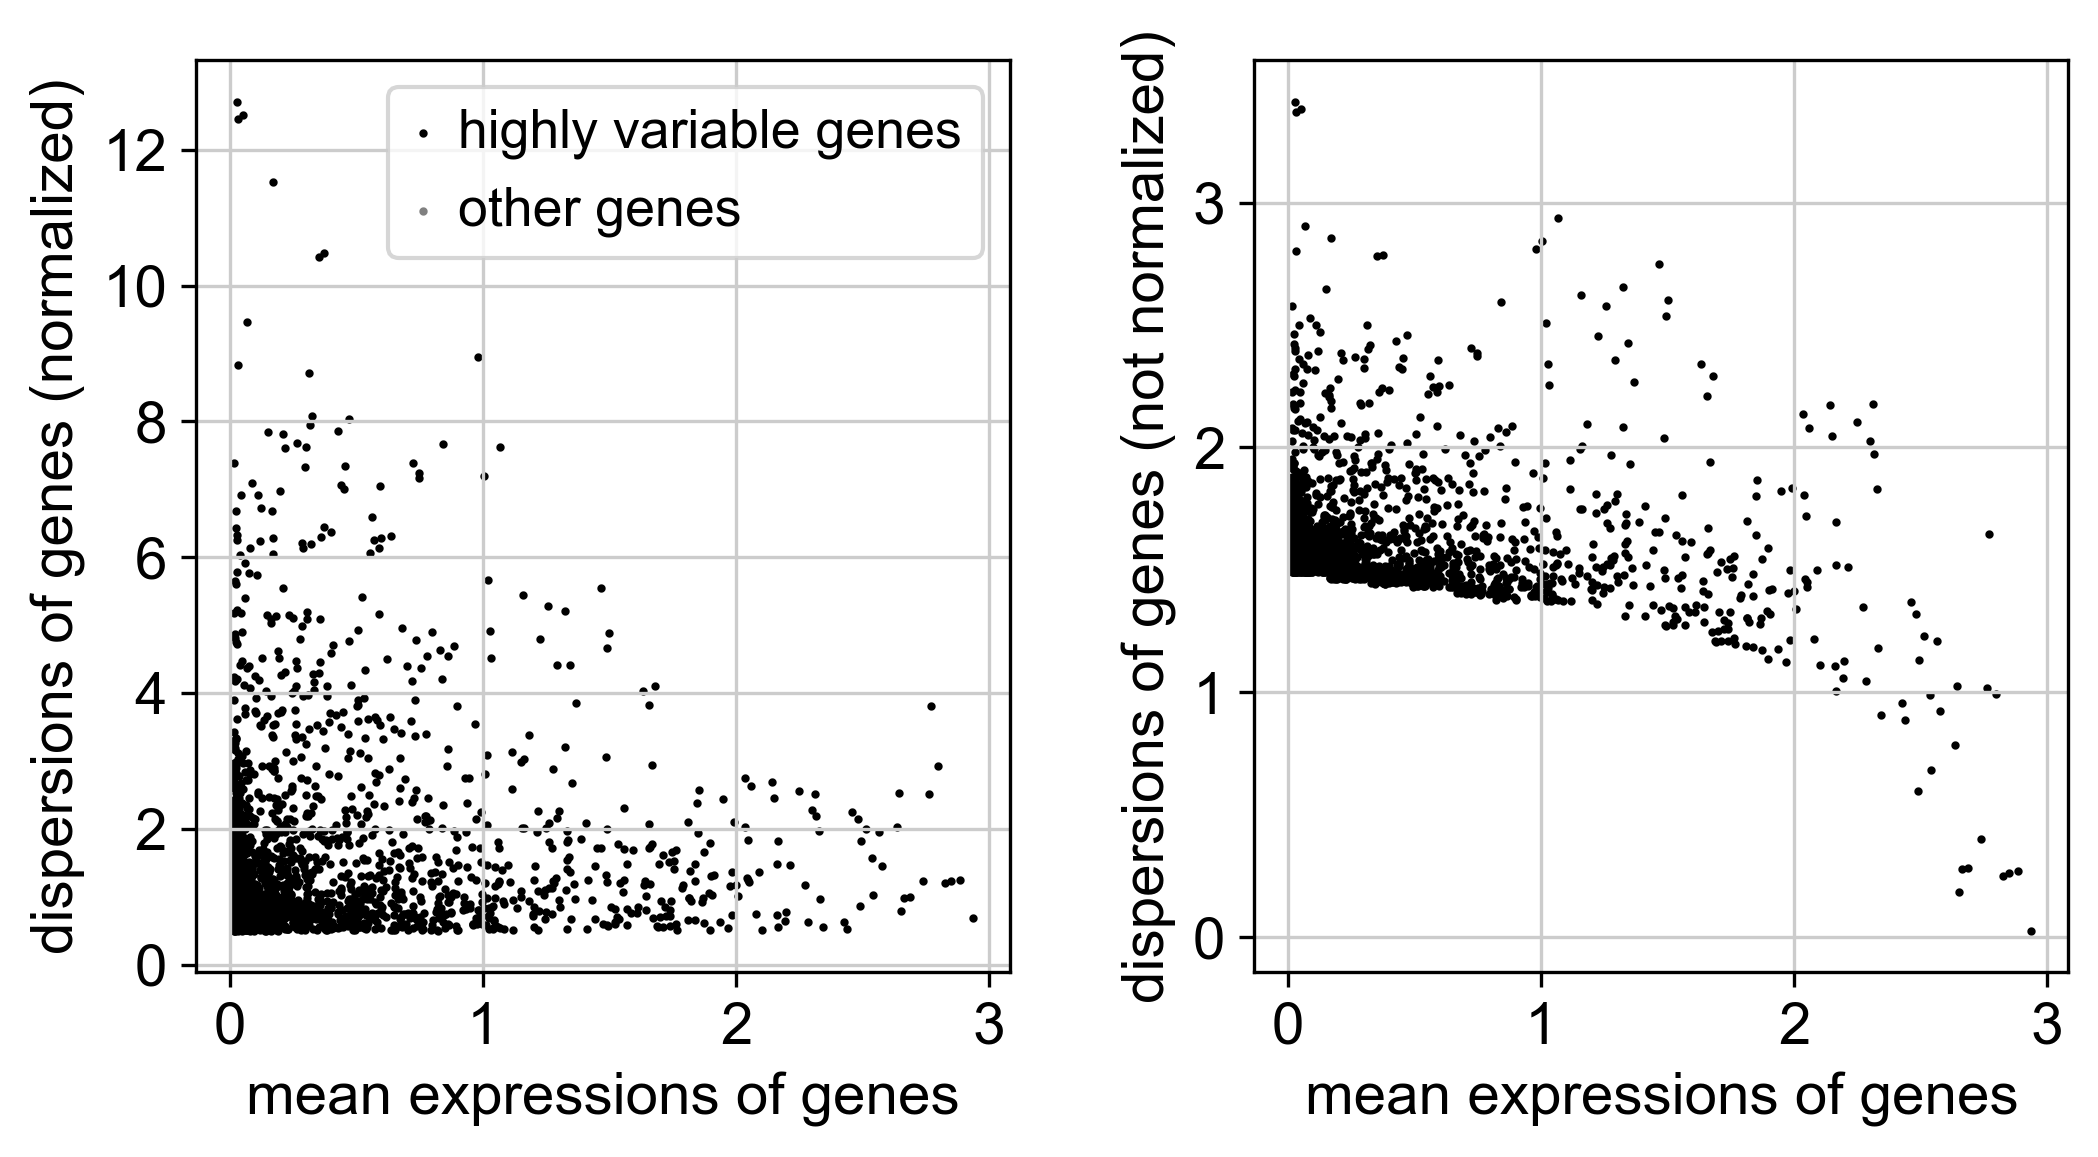

In [32]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.highly_variable_genes(adata, highly_variable_genes=True, log=False, show=False)
    plt.savefig("./figures/01d.HighlyVariableGenes.png", bbox_inches="tight", log=True)

In [33]:
adata.raw = adata

In [34]:
# adata.X = adata.obsm['raw'].copy()

In [35]:
print('Total number of observations: {:d}'.format(adata.n_obs))
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of observations: 6219
Number of genes after cell filter: 2222


In [36]:
#  Regress out effects of total counts per cell and the % mitochondrial genes expressed.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)   # Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [37]:
adata.var[adata.var.index.duplicated()]

Empty DataFrame
Columns: [genes_index, mt, ribo, hb, n_cells_by_counts, mean_counts, pct_dropout_by_counts, total_counts, n_cells, highly_variable, means, dispersions, dispersions_norm, mean, std]
Index: []

# = = = = = = = = 6. Sample sex = = = = = = = =

In [38]:
%%time
annot_columns = ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"]
annot = sc.queries.biomart_annotations("hsapiens", annot_columns,).set_index("external_gene_name")
# adata.var[annot.columns] = annot

Wall time: 30.8 s


In [39]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index([], dtype='object')

In [40]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1) / np.sum(adata.X, axis=1) * 100

In [41]:
adata.obs.sample(3)

percent_mito     n_counts  percent_hsp           barcode  \
index                                                                           
AAACCTGTCCGCGTTT-86      0.040062  2322.327148     0.003585  AAACCTGTCCGCGTTT   
TATCAGGTCTGTCTAT-79      0.046695  1833.514526     0.002623  TATCAGGTCTGTCTAT   
CGCTATCTCTTAGAGC-87      0.031340  2188.971680     0.110254  CGCTATCTCTTAGAGC   

                     batch        library_id cancer    patient tissue  \
index                                                                   
AAACCTGTCCGCGTTT-86     86  UCEC-P20190910-N   UCEC  P20190910      N   
TATCAGGTCTGTCTAT-79     79  UCEC-P20190213-T   UCEC  P20190213      T   
CGCTATCTCTTAGAGC-87     87  UCEC-P20190910-T   UCEC  P20190910      T   

                     n_genes  ... n_genes_by_counts total_counts  \
index                         ...                                  
AAACCTGTCCGCGTTT-86     1820  ...              1820  2322.327148   
TATCAGGTCTGTCTAT-79     1129  ...              1129  1833.514526   
CGCTATCTCTTAGAGC-87     1720  ...              1720  2188.971680   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
index                                                                   
AAACCTGTCCGCGTTT-86       39.679638       1.708615         198.319733   
TATCAGGTCTGTCTAT-79       35.798626       1.952459         207.782883   
CGCTATCTCTTAGAGC-87       34.875984       1.593259         217.658432   

                     pct_counts_ribo  total_counts_hb  pct_counts_hb  \
index                                                                  
AAACCTGTCCGCGTTT-86         8.539699         0.843918       0.036339   
TATCAGGTCTGTCTAT-79        11.332492         1.697520       0.092583   
CGCTATCTCTTAGAGC-87         9.943410         0.000000       0.000000   

                     percent_mt2  percent_chrY  
index                                           
AAACCTGTCCGCGTTT-86     0.017086          -0.0  
TATCAGGTCTGTCTAT-79     0.019525          -0.0  
CGCTATCTCTTAGAGC-87     0.015933           0.0  

[3 rows x 25 columns]

In [42]:
try:
    # color inputs must be from either .obs or .var, so add in XIST expression to obs.
    adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')]
    sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")
    sc.pl.violin(adata, ["percent_chrY"], jitter=0.4, groupby = 'patient', rotation= 45)
except:
    print("An exception occurred") 

An exception occurred


In [43]:
adata

AnnData object with n_obs × n_vars = 6219 × 2222
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'percent_chrY'
    var: 'genes_index', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'patient_colors', 'log1p', 'hvg'

# = = = = = = = = 7. Calculate cell-cycle scores = = = = = = = =

In [44]:
cell_cycle_genes = "./data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes = [x.strip() for x in open(cell_cycle_genes)]
print(len(cell_cycle_genes))

97


In [45]:
s_genes   = cell_cycle_genes[:43]; g2m_genes = cell_cycle_genes[43:]  # Split into 2 lists

In [46]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

20


In [47]:
#adata.raw = adata                                           # save normalized counts in raw slot.
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)  # normalize to depth 10,000
#sc.pp.log1p(adata)                                          # logaritmize
#sc.pp.scale(adata, max_value=10)                            # scale

In [48]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

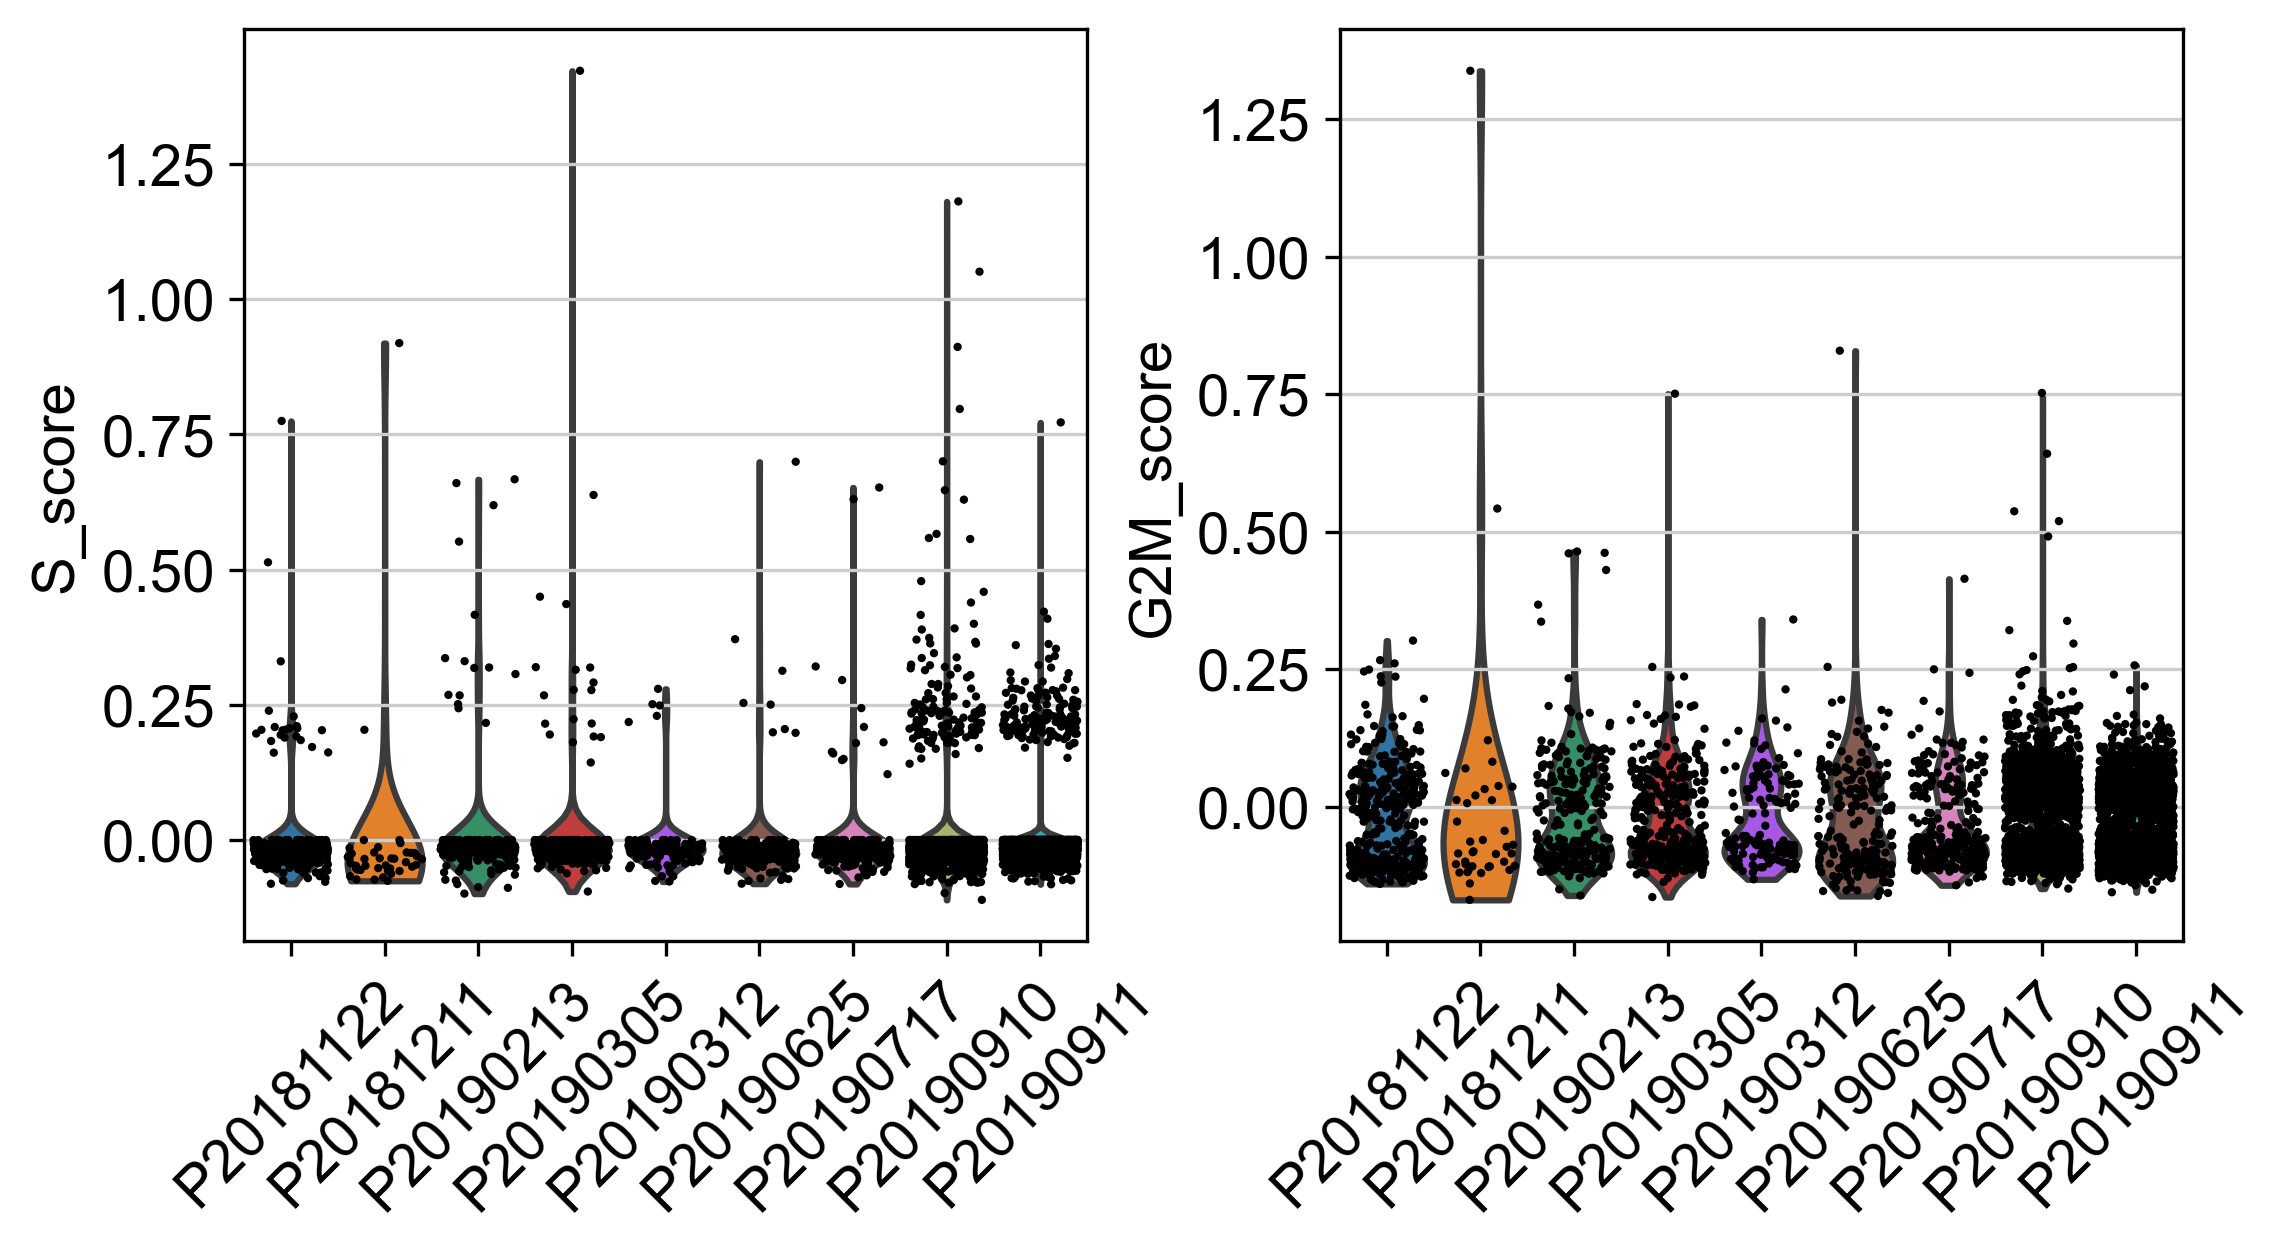

In [49]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], size=2, jitter=0.4, groupby = 'patient', rotation=45)

In [50]:
# = = = = = = = = 8.  Predict doublets = = = = = = = =

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 32.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 4.4 seconds


(<Figure size 1200x450 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

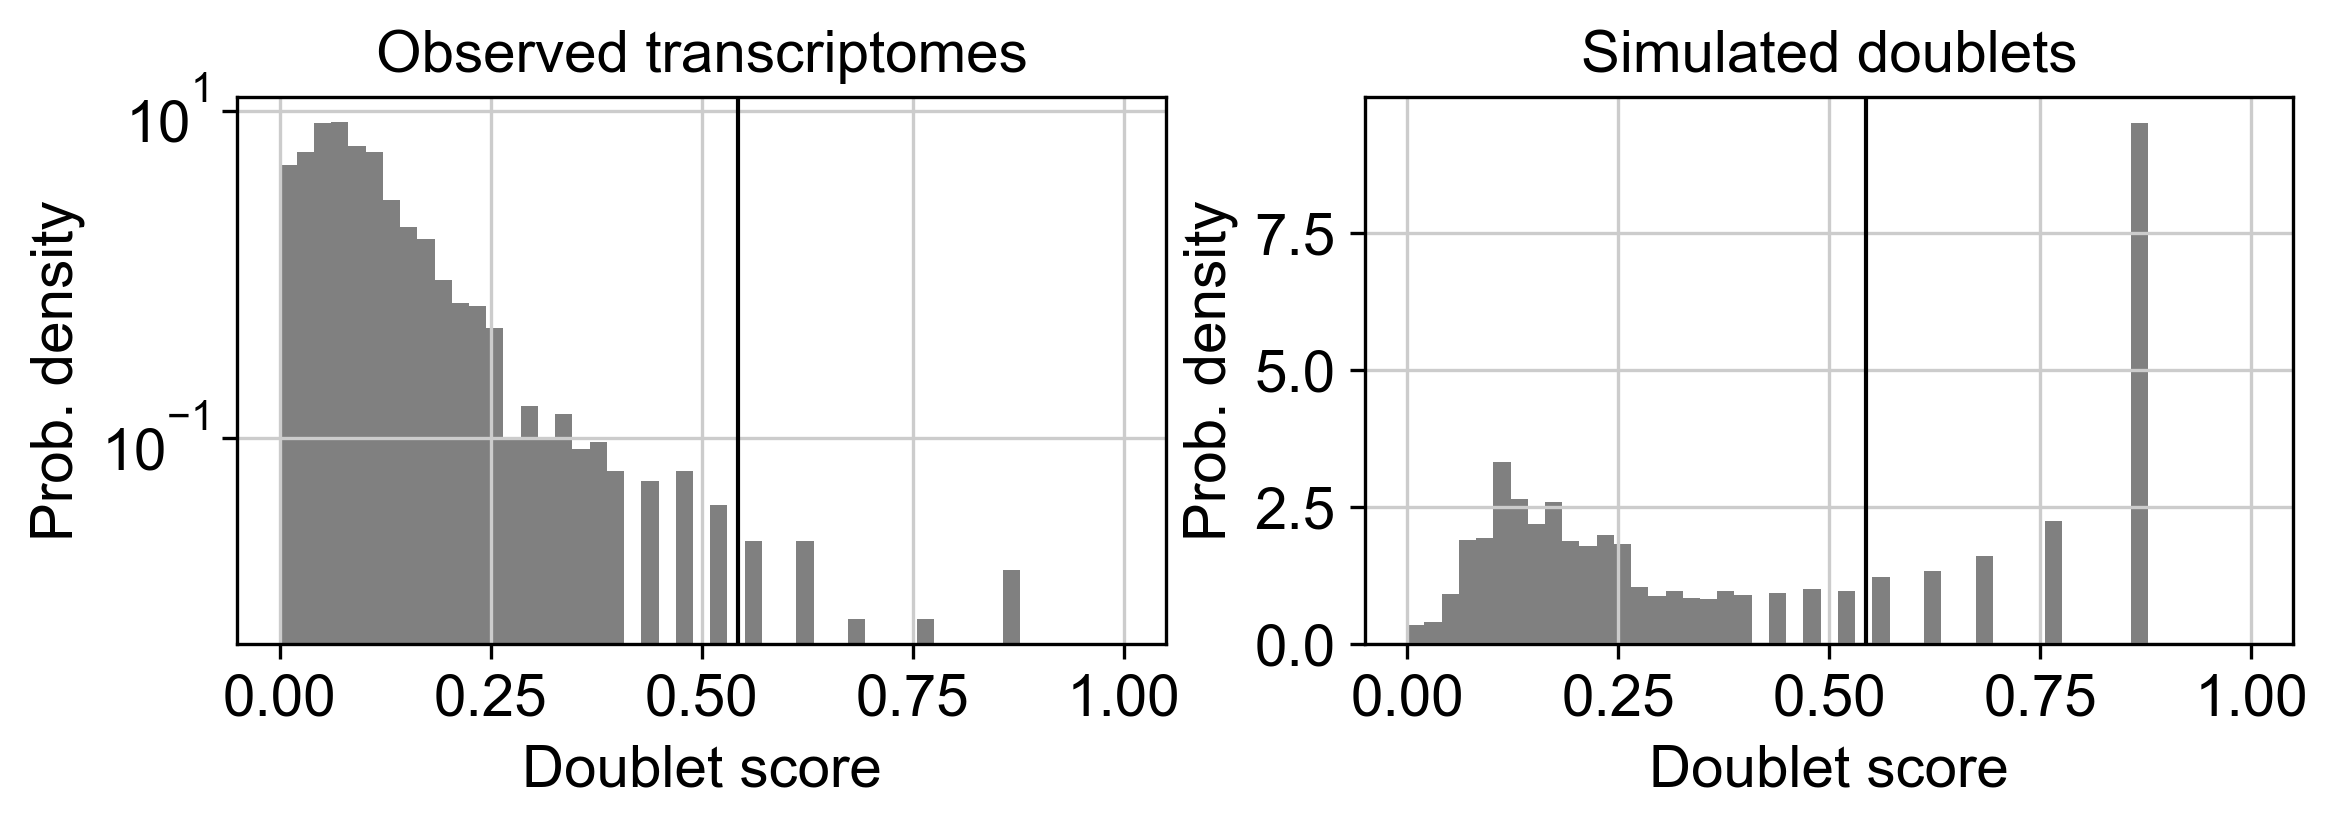

In [51]:
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [52]:
sum(adata.obs['predicted_doublets'])

10

In [53]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

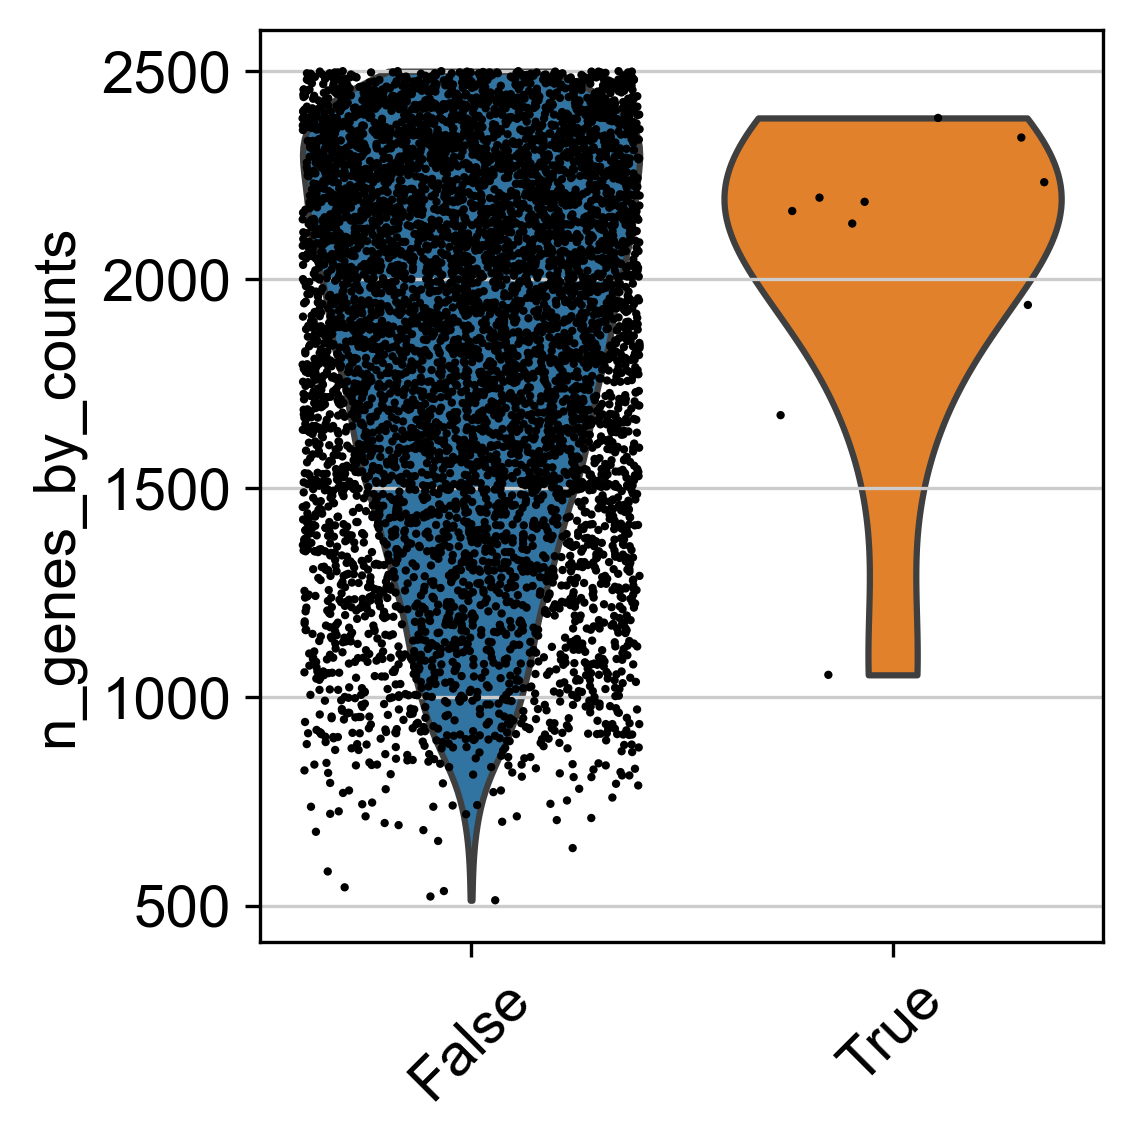

In [54]:
sc.pl.violin(adata, 'n_genes_by_counts', size=2, jitter=0.4, groupby = 'doublet_info', rotation=45)

In [55]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [56]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)   # Computing the neighborhood graph
sc.tl.umap(adata)

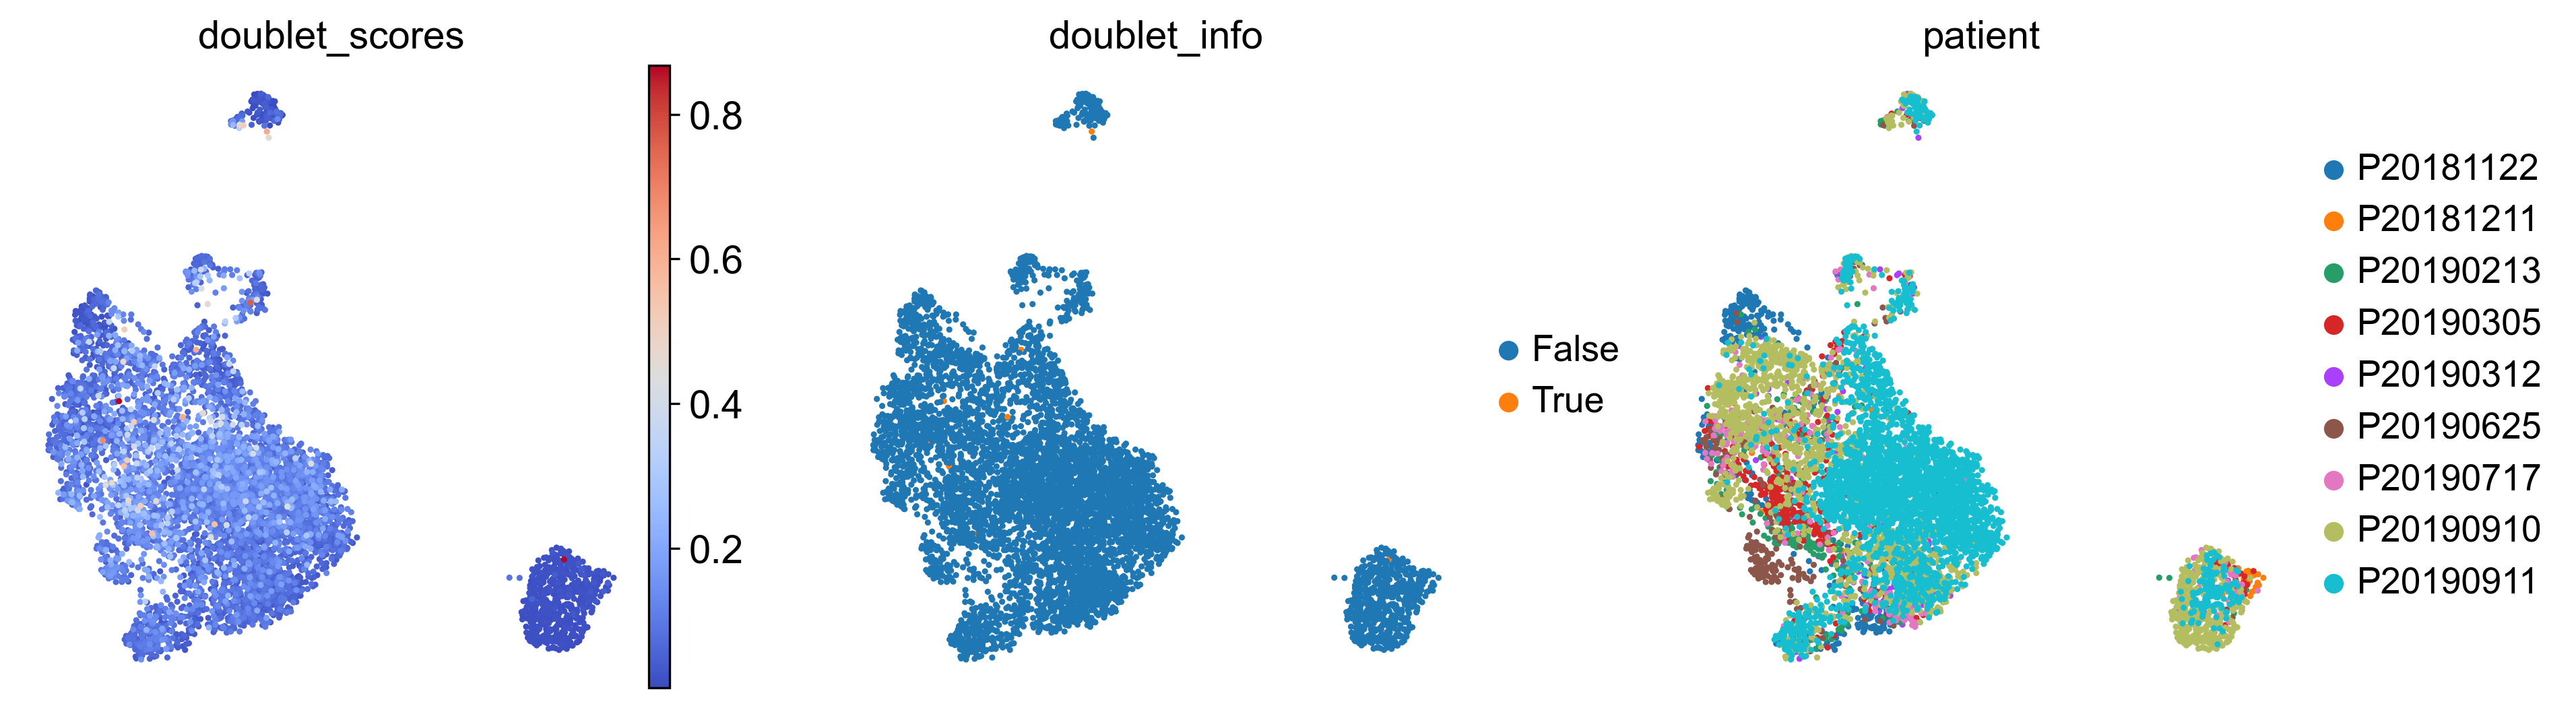

In [57]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','patient'])

In [58]:
adata = adata.raw.to_adata()               # revert back to the raw counts as the main matrix in adata.
adata = adata[adata.obs['doublet_info'] == 'False',:]    # remove all predicted doublets from our data.

In [59]:
adata.obs.head(3)

percent_mito     n_counts  percent_hsp           barcode  \
index                                                                           
AAACCTGAGTTCGCAT-73      0.027192  2133.141602     0.000917  AAACCTGAGTTCGCAT   
AACACGTCATATGGTC-73      0.038902  2162.840332     0.005572  AACACGTCATATGGTC   
AACTCAGTCGCCATAA-73      0.038217  1897.397217     0.002248  AACTCAGTCGCCATAA   

                     batch        library_id cancer    patient tissue  \
index                                                                   
AAACCTGAGTTCGCAT-73     73  UCEC-P20190312-N   UCEC  P20190312      N   
AACACGTCATATGGTC-73     73  UCEC-P20190312-N   UCEC  P20190312      N   
AACTCAGTCGCCATAA-73     73  UCEC-P20190312-N   UCEC  P20190312      N   

                     n_genes  ... total_counts_hb pct_counts_hb percent_mt2  \
index                         ...                                             
AAACCTGAGTTCGCAT-73     1634  ...        0.832358      0.039020    0.015758   
AACACGTCATATGGTC-73     2043  ...        0.000000      0.000000    0.018607   
AACTCAGTCGCCATAA-73     1046  ...        3.148680      0.165947    0.017821   

                     percent_chrY   S_score  G2M_score  phase  doublet_scores  \
index                                                                           
AAACCTGAGTTCGCAT-73          -0.0 -0.012534  -0.064743     G1        0.078431   
AACACGTCATATGGTC-73           0.0 -0.010781  -0.097206     G1        0.147059   
AACTCAGTCGCCATAA-73          -0.0 -0.018087  -0.083506     G1        0.056985   

                     predicted_doublets  doublet_info  
index                                                  
AAACCTGAGTTCGCAT-73               False         False  
AACACGTCATATGGTC-73               False         False  
AACTCAGTCGCCATAA-73               False         False  

[3 rows x 31 columns]

In [60]:
adata.var.head(3)

genes_index     mt   ribo     hb  n_cells_by_counts  \
RP4-669L17.10  RP4-669L17.10  False  False  False                 31   
RP11-206L10.9  RP11-206L10.9  False  False  False                 56   
PLEKHN1              PLEKHN1  False  False  False                 48   

               mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
RP4-669L17.10     0.002607              99.648047     22.965256       31   
RP11-206L10.9     0.004438              99.364214     39.087399       56   
PLEKHN1           0.003812              99.455041     33.578110       48   

               highly_variable     means  dispersions  dispersions_norm  
RP4-669L17.10             True  0.013059     1.543891          0.838464  
RP11-206L10.9             True  0.018095     1.509781          0.621812  
PLEKHN1                   True  0.014849     1.514872          0.654149

In [61]:
adata.write(results_file)   # Save the result.

In [62]:
print("'01_QualityControl.v001' script run time:", f'{time.time()-start:.0f}', "seconds.")

'01_QualityControl.v001' script run time: 204 seconds.


In [63]:
#   =   =   =   =    =   =   =   =   STOP   =   =   =   =    =   =   =   =   